## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, TokenizerChar, word_split, normalize_to_ascii, pair_freq
from src.utils import loader, saver


import os, re
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.data_cleaning import read_first_n
import re
import random

# disable gpu for testing purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
coqa = loader("corpus/coqa_raw")
math = loader("corpus/math_raw")
hotpot = loader("corpus/hotpot_raw")
quac = loader("corpus/quac_raw")
squad = loader("corpus/squad_raw")
recipe = loader("corpus/recipe_raw")
recipe_qa = loader("corpus/recipe_qa_raw")
recipe_qa_ingred = loader("corpus/recipe_qa_ingred_raw")
trivia_web = loader("corpus/trivia_web_raw")
trivia_wiki = loader("corpus/trivia_wiki_raw")
urbanDict = loader("corpus/urbanDict_raw")

In [3]:
def flatten_list(nested_list):
    """Flatten a nested list."""
    list_flatten = []
    for sublist in nested_list:
        if isinstance(sublist, list):
            list_flatten.extend(flatten_list(sublist))
        else:
            list_flatten.append(sublist)
    return list_flatten

In [4]:
corpus_flatten = flatten_list(coqa + math + hotpot + quac + squad + recipe + recipe_qa + recipe_qa_ingred + trivia_web + trivia_wiki + urbanDict) 
random.seed(42)
random.shuffle(corpus_flatten)

length = len(corpus_flatten)
print(f"Total number of entries: {length}")
print(f"Total number of characters: {sum(len(entry) for entry in corpus_flatten)}")

Total number of entries: 2342627
Total number of characters: 2040139025


In [6]:
tokenizer = TokenizerBPE(corpus_flatten[:int(length * 0.05)], num_merges=32000)

Char tokenization
Char tokenization complete
148875212 tokens in corpus
Merging tokens


  0%|          | 0/32000 [00:00<?, ?it/s]

  t 2228584
  a 1895296
h e 1648461
i n 1639781
  s 1162655
r e 1160697
 t he 1145718
  c 1110059
  o 1085313
e r 1041834
  w 887484
o n 859450
  b 833417
n d 762287
  f 728219
  p 726431
a t 720680
  m 712980
e d 679982
e n 658822
o r 655685
e s 649015
i t 633882
i s 632697
  in 628421
a r 627763
a n 626961
a l 549917
 o f 531940
  d 526444
 a nd 513115
in g 486705
o u 476334
i c 454226
  h 451692
a s 438001
 t o 421841
  l 411296
  1 389407
r o 381812
i on 365507
i l 358284
  g 307313
  n 306174
e l 300366
  re 293583
en t 275934
  e 269577
 t h 259848
l e 258860
s t 244615
o m 228063
u t 220301
a m 219434
c t 217545
e t 206211
 f or 205689
o l 203875
 o n 202970
  u 199192
 s t 195178
a d 190031
l y 183491
 b e 180095
o t 178366
  he 173859
a c 173412
  is 172554
v e 171547
i r 171475
i m 169915
o w 168848
i d 168759
u r 161341
i g 161171
v er 158678
  2 156538
 w h 155432
it h 155071
  r 148738
 w ith 146391
a y 144339
 w as 143796
 a s 143169
 c h 139380
t er 137138
c h 133797
c e

In [9]:
saver("corpus/tokenizer_bpe_32000.pkl", tokenizer)

## Tokenize text

In [3]:
tokenizer = loader("corpus/tokenizer_bpe_32000.pkl")
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>", "<pad>"])

In [4]:
def fused_sqa_multiple(story_list, question_grouped_list, answer_grouped_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for story, question_list, answer_list in tqdm(list(zip(story_list, question_grouped_list, answer_grouped_list))):
        sqa = [sos, story]
        for question, answer in zip(question_list, answer_list):
            sqa.append(q)
            sqa.append(question)
            sqa.append(a)
            sqa.append(answer)
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

def fused_sqa(story_list, question_list, answer_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for story, question, answer in tqdm(list(zip(story_list, question_list, answer_list))):
        sqa = [sos, story]
        sqa.append(q)
        sqa.append(question)
        sqa.append(a)
        sqa.append(answer)
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list


def fused_qa(question_list, answer_list):
    q ="<q>"
    a = "<a>"
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for question, answer in tqdm(list(zip(question_list, answer_list))):
        sqa = [sos]
        sqa.append(q)
        sqa.append(question)
        sqa.append(a)
        sqa.append(answer)
        sqa.append(eos)
        corpus_list.append("".join(sqa))
        
    return corpus_list

def fused_article(story_list):
    sos = "<s>"
    eos = "</s>"

    corpus_list = []
    for story in tqdm(story_list):
        corpus_list.append("".join([sos, story, eos]))
    return corpus_list



def pack_and_pad_corpus(corpus, max_length, tokenizer):
    pad_token = tokenizer.token_to_idx["<pad>"]
    
    packed_corpus = []         # finished blocks
    current_block = []         # list of lines accumulating into the next block
    current_length = 0         # current total tokens in the block

    for line in tqdm(corpus):
        line = torch.tensor(line, dtype=torch.long).unsqueeze(0)  # (1, line_length)
        # make sure we’re on the same device for later cat / pad
        device = line.device

        line_len = line.shape[1]

        # 1. Truncate overly long lines
        if line_len > max_length:
            line = line[:, :max_length]
            line_len = max_length

        # 2. If adding this line would overflow the block, flush the block first
        if current_length + line_len > max_length:
            combined = torch.cat(current_block, dim=1)        # (B, current_length)
            padding_needed = max_length - combined.shape[1]

            if padding_needed > 0:
                pad = torch.full(
                    (combined.shape[0], padding_needed),
                    pad_token,
                    dtype=combined.dtype,
                    device=device,
                )
                combined = torch.cat([combined, pad], dim=1)  # (B, max_length)

            packed_corpus.append(combined)
            current_block = [line]
            current_length = line_len
        else:
            # Still room in the current block
            current_block.append(line)
            current_length += line_len

    # 3. Handle remaining lines after loop ends
    if current_block:
        combined = torch.cat(current_block, dim=1)
        padding_needed = max_length - combined.shape[1]

        if padding_needed > 0:
            pad = torch.full(
                (combined.shape[0], padding_needed),
                pad_token,
                dtype=combined.dtype,
                device=combined.device,
            )
            combined = torch.cat([combined, pad], dim=1)

        packed_corpus.append(combined)

    # 4. Collate all blocks along the batch dimension
    return torch.cat(packed_corpus, dim=0)


### Recipe

In [17]:
recipe_text = fused_article(recipe)
recipe_encoded = tokenizer.encode("".join(recipe_text))
saver("corpus/recipe_bpe_32000.pkl", recipe_encoded)

  0%|          | 0/200002 [00:00<?, ?it/s]

In [18]:
recipe_qa_text = fused_qa(recipe_qa[0], recipe_qa[1])
recipe_encoded = tokenizer.encode("".join(recipe_qa_text))
saver("corpus/recipe_qa_bpe_32000.pkl", recipe_encoded)

  0%|          | 0/200001 [00:00<?, ?it/s]

In [19]:
recipe_qa_ingred_text = fused_qa(recipe_qa_ingred[0], recipe_qa_ingred[1])
recipe_qa_encoded = tokenizer.encode("".join(recipe_qa_ingred_text))
saver("corpus/recipe_qa_ingred_bpe_32000.pkl", recipe_encoded)

  0%|          | 0/200001 [00:00<?, ?it/s]

### COQA

In [58]:
coqa_text = fused_sqa_multiple(coqa[0], coqa[1], coqa[2])
coqa_encoded = [tokenizer.encode(text) for text in tqdm(coqa_text)]
saver("corpus/coqa_bpe_32000.pkl", coqa_encoded)

  0%|          | 0/7199 [00:00<?, ?it/s]

  0%|          | 0/7199 [00:00<?, ?it/s]

In [118]:
coqa_packed = pack_and_pad_corpus(coqa_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/coqa_bpe_32000_packed.pt", coqa_packed)

  0%|          | 0/7199 [00:00<?, ?it/s]

### Math

In [86]:
math = fused_qa(math[0], math[1])
math_encoded = [tokenizer.encode(text) for text in tqdm(math)]
saver("corpus/math_bpe_32000.pkl", math_encoded)

  0%|          | 0/7473 [00:00<?, ?it/s]

  0%|          | 0/7473 [00:00<?, ?it/s]

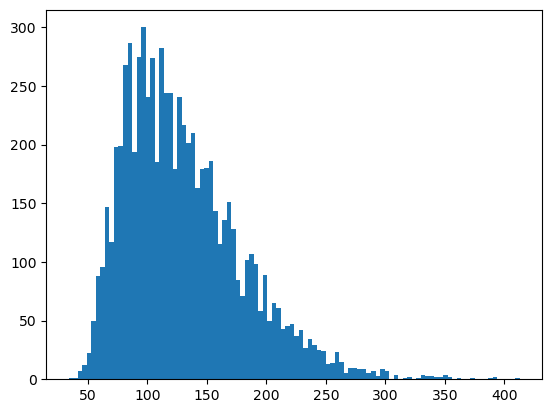

In [100]:
len_list = [len(text) for text in math_encoded]
plt.hist(len_list, bins=100)
plt.show()

In [119]:
math_packed = pack_and_pad_corpus(math_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/math_bpe_32000_packed.pt", math_packed)

  0%|          | 0/7473 [00:00<?, ?it/s]

### Hotpot

In [10]:
hotpot = loader("corpus/hotpot_raw")
print(len("".join(hotpot[0])))

hotpot_text = fused_sqa(hotpot[0], hotpot[1], hotpot[2])
hotpot_encoded = [tokenizer.encode(text) for text in tqdm(hotpot_text)]
saver("corpus/hotpot_bpe_32000.pkl", hotpot_encoded)

75913201


  0%|          | 0/90447 [00:00<?, ?it/s]

  0%|          | 0/90447 [00:00<?, ?it/s]

In [11]:
hotpot_packed = pack_and_pad_corpus(hotpot_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/hotpot_bpe_32000_packed.pt", hotpot_packed)

  0%|          | 0/90447 [00:00<?, ?it/s]

In [12]:
hotpot = loader("corpus/hotpot_noRed_raw")
print(len("".join(hotpot[0])))

hotpot_text = fused_sqa(hotpot[0], hotpot[1], hotpot[2])
hotpot_encoded = [tokenizer.encode(text) for text in tqdm(hotpot_text)]
saver("corpus/hotpot_noRed_bpe_32000.pkl", hotpot_encoded)

30912553


  0%|          | 0/90447 [00:00<?, ?it/s]

  0%|          | 0/90447 [00:00<?, ?it/s]

In [13]:
hotpot_noRed_packed = pack_and_pad_corpus(hotpot_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/hotpot_noRed_bpe_32000_packed.pt", hotpot_noRed_packed)

  0%|          | 0/90447 [00:00<?, ?it/s]

## QUAC

In [68]:
quac_text = fused_sqa_multiple(quac[0], quac[1], quac[2])
quac_encoded = [tokenizer.encode(text) for text in tqdm(quac_text)]
saver("corpus/quac_bpe_32000.pkl", quac_encoded)

  0%|          | 0/11567 [00:00<?, ?it/s]

  0%|          | 0/11567 [00:00<?, ?it/s]

In [128]:
quac_packed = pack_and_pad_corpus(quac_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/quac_bpe_32000_packed.pt", quac_packed)

  0%|          | 0/11567 [00:00<?, ?it/s]

## SQUAD

In [72]:
squad_text = fused_sqa_multiple(squad[0], squad[1], squad[2])
squad_encoded = [tokenizer.encode(text) for text in tqdm(squad_text)]
saver("corpus/squad_bpe_32000.pkl", squad_encoded)

  0%|          | 0/19035 [00:00<?, ?it/s]

  0%|          | 0/19035 [00:00<?, ?it/s]

In [129]:
squad_packed = pack_and_pad_corpus(squad_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/squad_bpe_32000_packed.pt", squad_packed)

  0%|          | 0/19035 [00:00<?, ?it/s]

### Trivia Web

In [70]:
trivia_web_text = fused_article(trivia_web[0])
trivia_web_encoded = [tokenizer.encode(text) for text in tqdm(trivia_web_text)]
saver("corpus/trivia_web_bpe_32000.pkl", trivia_web_encoded)

  0%|          | 0/64719 [00:00<?, ?it/s]

  0%|          | 0/64719 [00:00<?, ?it/s]

### Trivia Wiki

In [71]:
trivia_wiki_text = fused_article(trivia_wiki[0])
trivia_wiki_encoded = [tokenizer.encode(text) for text in tqdm(trivia_wiki_text)]
saver("corpus/trivia_wiki_bpe_32000.pkl", trivia_wiki_encoded)

  0%|          | 0/28406 [00:00<?, ?it/s]

  0%|          | 0/28406 [00:00<?, ?it/s]

## Trivia Questions

In [8]:
trivia_wiki_qa_text = fused_qa(trivia_wiki[1], trivia_wiki[2])
trivia_wiki_qa_encoded = [tokenizer.encode(text) for text in tqdm(trivia_wiki_qa_text)]
saver("corpus/trivia_wiki_qa_bpe_32000.pkl", trivia_wiki_qa_encoded)

  0%|          | 0/61888 [00:00<?, ?it/s]

  0%|          | 0/61888 [00:00<?, ?it/s]

In [10]:
trivia_wiki_qa_packed = pack_and_pad_corpus(trivia_wiki_qa_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/trivia_wiki_qa_bpe_32000_packed.pt", trivia_wiki_qa_packed)

  0%|          | 0/61888 [00:00<?, ?it/s]

In [9]:
trivia_web_qa_text = fused_qa(trivia_web[1], trivia_web[2])
trivia_web_qa_encoded = [tokenizer.encode(text) for text in tqdm(trivia_web_qa_text)]
saver("corpus/trivia_web_qa_bpe_32000.pkl", trivia_web_qa_encoded)

  0%|          | 0/76496 [00:00<?, ?it/s]

  0%|          | 0/76496 [00:00<?, ?it/s]

In [11]:
trivia_web_qa_packed = pack_and_pad_corpus(trivia_web_qa_encoded, max_length=1024, tokenizer=tokenizer)
saver("corpus/trivia_web_qa_bpe_32000_packed.pt", trivia_web_qa_packed)

  0%|          | 0/76496 [00:00<?, ?it/s]

## 